In [1]:
import psycopg2
import sqlalchemy

import pandas as pd
import numpy as np

import time

from ftplib import FTP
import os
import re
import py7zr

import glob

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler 

In [2]:
%pip install findspark
%pip install pyspark

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("app").getOrCreate()

In [4]:
from pyspark.sql.types import StructType, StructField, StringType

def criar_esquema_csv(campos):
    csvSchema = StructType([
        StructField(campo, StringType(), True) for campo in campos
    ])
    return csvSchema

In [6]:
# Juntando os arquivos baixados
path_files = 'C:/Users/thiago.silva/TCC/CAGED/dados'

In [34]:
campos = ['competênciamov', 'região', 'uf', 'município', 'seção', 'subclasse', 'saldomovimentação',
          'cbo2002ocupação', 'categoria', 'graudeinstrução', 'idade', 'horascontratuais', 'raçacor',
          'sexo', 'tipoempregador', 'tipoestabelecimento', 'tipomovimentação', 'tipodedeficiência',
          'indtrabintermitente', 'indtrabparcial', 'salário', 'tamestabjan', 'indicadoraprendiz',
          'origemdainformação', 'competênciadec', 'competênciaexc', 'indicadordeexclusão',
          'indicadordeforadoprazo', 'unidadesaláriocódigo', 'valorsaláriofixo', 'ano_mes']

schema_EXC = criar_esquema_csv(campos)

files_EXC_csv = []
for nome_arquivo in os.listdir(path_files):
    if nome_arquivo.startswith("CAGEDEXC") and nome_arquivo.endswith(".csv"):
        files_EXC_csv.append(path_files+"/"+nome_arquivo)
 
df_exc = spark.read.csv(files_EXC_csv, header=None, schema=schema_EXC, sep=';', encoding='utf-8')

In [7]:
campos = ['competênciamov', 'região', 'uf', 'município', 'seção', 'subclasse', 'saldomovimentação',
          'cbo2002ocupação', 'categoria', 'graudeinstrução', 'idade', 'horascontratuais', 'raçacor',
          'sexo', 'tipoempregador', 'tipoestabelecimento', 'tipomovimentação', 'tipodedeficiência',
          'indtrabintermitente', 'indtrabparcial', 'salário', 'tamestabjan', 'indicadoraprendiz',
          'origemdainformação', 'competênciadec', 'indicadordeforadoprazo', 
          'unidadesaláriocódigo', 'valorsaláriofixo', 'ano_mes']

schema = criar_esquema_csv(campos)

files_FOR_csv = []
for nome_arquivo in os.listdir(path_files):
    if nome_arquivo.startswith("CAGEDFOR") and nome_arquivo.endswith(".csv"):
        files_FOR_csv.append(path_files+"/"+nome_arquivo)
 
df_for= spark.read.csv(files_FOR_csv, header=None, schema=schema, sep=';', encoding='utf-8')

files_MOV_csv = []
for nome_arquivo in os.listdir(path_files):
    if nome_arquivo.startswith("CAGEDMOV") and nome_arquivo.endswith(".csv"):
        files_MOV_csv.append(path_files+"/"+nome_arquivo)
 
df_mov= spark.read.csv(files_MOV_csv, header=None, schema=schema, sep=';', encoding='utf-8')

In [58]:
df_exc.groupBy('ano_mes').count().orderBy('ano_mes').show()

+-------+-----+
|ano_mes|count|
+-------+-----+
| 202004|  780|
| 202005| 3871|
| 202006| 2768|
| 202007| 3136|
| 202008| 3823|
| 202009| 3424|
| 202010| 2882|
| 202011| 3090|
| 202012| 3154|
| 202101| 4553|
| 202102| 3592|
| 202103| 5983|
| 202104| 7688|
| 202105|31276|
| 202106|24404|
| 202107|10007|
| 202108|11625|
| 202109| 8087|
| 202110|23806|
| 202111|13631|
+-------+-----+
only showing top 20 rows



In [60]:
df_for.groupBy('ano_mes').count().orderBy('ano_mes').show()

+-------+------+
|ano_mes| count|
+-------+------+
| 202002| 87829|
| 202003|132678|
| 202004|239832|
| 202005|158679|
| 202006|133774|
| 202007|227940|
| 202008|127503|
| 202009|116028|
| 202010|123246|
| 202011|131832|
| 202012|156722|
| 202101|182458|
| 202102|195641|
| 202103|218746|
| 202104|238378|
| 202105|537224|
| 202106|316226|
| 202107|171865|
| 202108|243829|
| 202109|157879|
+-------+------+
only showing top 20 rows



In [36]:
df_mov.groupBy('ano_mes').count().orderBy('ano_mes').show()

+-------+-------+
|ano_mes|  count|
+-------+-------+
| 202001|2677294|
| 202002|2769296|
| 202003|2927646|
| 202004|2137605|
| 202005|1785450|
| 202006|1843463|
| 202007|2000499|
| 202008|2276599|
| 202009|2499928|
| 202010|2753866|
| 202011|2696726|
| 202012|2594612|
| 202101|2843091|
| 202102|3032935|
| 202103|3077440|
| 202104|2678700|
| 202105|2837927|
| 202106|2909460|
| 202107|3015377|
| 202108|3265478|
+-------+-------+
only showing top 20 rows



In [12]:
df_exc.count()

289477

In [13]:
df_for.count()

6335576

In [14]:
df_mov.count()

119458057

In [53]:
df_caged = df_mov.groupBy('tipomovimentação','cbo2002ocupação','ano_mes').count().orderBy('ano_mes')

In [84]:
df_caged.show()

+----------------+---------------+-------+-----+
|tipomovimentação|cbo2002ocupação|ano_mes|count|
+----------------+---------------+-------+-----+
|              45|         821445| 202001|   16|
|              31|         521125| 202001|10777|
|              31|         231305| 202001|  132|
|              90|         513405| 202001|  170|
|              20|         342310| 202001|  149|
|              31|         519940| 202001| 1355|
|              10|         422105| 202001| 1571|
|              31|         519905| 202001|  236|
|              20|         231210| 202001| 3802|
|              40|         351605| 202001|  786|
|              10|         828110| 202001|   48|
|              31|         322130| 202001|  298|
|              40|         715505| 202001|  639|
|              10|         515105| 202001|   33|
|              20|         517115| 202001|  379|
|              31|         763015| 202001|  146|
|              40|         354305| 202001|  141|
|              20|  

In [90]:
df_caged.select(col("cbo2002ocupação")).distinct().count()

2677

**Clusterização para as ocupações**

In [8]:
# Extrair uma amostra aleatória de 1% dos dados
df_mov10 = df_mov.sample(withReplacement=False, fraction=0.01, seed=42)

In [9]:
df_mov10_pd = df_mov10.toPandas()

In [39]:
df_mov10_pd.head()

,competênciamov,região,uf,município,seção,subclasse,saldomovimentação,cbo2002ocupação,categoria,graudeinstrução,...,indtrabparcial,salário,tamestabjan,indicadoraprendiz,origemdainformação,competênciadec,indicadordeforadoprazo,unidadesaláriocódigo,valorsaláriofixo,ano_mes
0,202001,3,31,314610,F,4211101,1,710210,101,4,...,0,"3238,11",3,0,1,202001,0,5,"3238,11",202001
1,202001,3,33,330455,G,4722901,-1,521125,999,5,...,0,"1234,57",5,0,2,202001,0,99,None,202001
2,202001,2,29,292870,N,7830200,1,862305,101,7,...,0,"1275,56",9,0,1,202001,0,5,"1275,56",202001
3,202001,2,27,270930,G,4731800,-1,521135,101,7,...,0,"1039,00",2,0,1,202001,0,5,"1039,00",202001
4,202001,3,35,355030,F,4330404,-1,717020,101,7,...,0,"1513,92",3,0,1,202001,0,5,"1513,92",202001


In [40]:
print(f'O dataset possui {df_mov10_pd.shape[1]} colunas')

O dataset possui 29 colunas


In [151]:
df_mov10_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194791 entries, 0 to 1194790
Data columns (total 29 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   competênciamov          1194791 non-null  object
 1   região                  1194791 non-null  object
 2   uf                      1194791 non-null  object
 3   município               1194791 non-null  object
 4   seção                   1194791 non-null  object
 5   subclasse               1194791 non-null  object
 6   saldomovimentação       1194791 non-null  object
 7   cbo2002ocupação         1194791 non-null  object
 8   categoria               1194791 non-null  object
 9   graudeinstrução         1194791 non-null  object
 10  idade                   1194724 non-null  object
 11  horascontratuais        1193339 non-null  object
 12  raçacor                 1194791 non-null  object
 13  sexo                    1194791 non-null  object
 14  tipoempregador    

In [44]:
print(df_mov10_pd.isnull().sum())

competênciamov                0
região                        0
uf                            0
município                     0
seção                         0
subclasse                     0
saldomovimentação             0
cbo2002ocupação               0
categoria                     0
graudeinstrução               0
idade                        67
horascontratuais           1452
raçacor                       0
sexo                          0
tipoempregador                0
tipoestabelecimento           0
tipomovimentação              0
tipodedeficiência             0
indtrabintermitente           0
indtrabparcial                0
salário                     511
tamestabjan                   0
indicadoraprendiz             0
origemdainformação            0
competênciadec                0
indicadordeforadoprazo        0
unidadesaláriocódigo          0
valorsaláriofixo          45208
ano_mes                       0
dtype: int64


In [10]:
# Excluir os registros que foram gerados equivocadamente com o nome da coluna
# Basta excluir um que os demais serão removidos em conjunto
df_mov10_pd = df_mov10_pd.loc[df_mov10_pd['competênciamov'] != 'competênciamov']

In [11]:
colunas_nulas = df_mov10_pd.columns[df_mov10_pd.isnull().any()].tolist()

In [12]:
for coluna in colunas_nulas:
    print(coluna)
    # Converter a coluna para tipo numérico
    df_mov10_pd.loc[:, coluna] = df_mov10_pd[coluna].str.replace(',', '.').str.strip()
    df_mov10_pd.loc[:, coluna] = pd.to_numeric(df_mov10_pd[coluna], errors='coerce')

idade


C:\Users\thiago.silva\AppData\Local\Temp\ipykernel_16732\3723654207.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_mov10_pd.loc[:, coluna] = pd.to_numeric(df_mov10_pd[coluna], errors='coerce')


horascontratuais
salário
valorsaláriofixo


In [13]:
# Iterar sobre as colunas com nulos para imputar os valores nulos considerando quem está
# na mesma UF, mesma CBO, mesmo grau de instrução e mesmo sexo
for coluna in colunas_nulas:
    print(coluna)
    # Calcular a média dos valores não nulos para cada combinação 
    media_valores = df_mov10_pd.groupby(['uf', 'cbo2002ocupação','graudeinstrução','sexo'])[coluna].mean()
    # Juntar os valores médios calculados de volta ao DataFrame original
    df_mov10_pd = df_mov10_pd.merge(media_valores, on=['uf', 'cbo2002ocupação','graudeinstrução','sexo'], suffixes=('', '_media'))
    # Substituir os valores nulos pela média correspondente
    df_mov10_pd[coluna].fillna(df_mov10_pd[coluna+'_media'], inplace=True)
    # Remover a coluna de médias, se necessário
    df_mov10_pd.drop(columns=[coluna+'_media'], inplace=True)

idade
horascontratuais
salário
valorsaláriofixo


In [14]:
# Removendo registros que ainda contenham valores ausentes em razão de não ter sido possível montar
# um agrupamento de 'uf', 'cbo2002ocupação','graudeinstrução','sexo' que tivesse mais de um registro.
# Nesse caso, os registros serão removidos
for coluna in colunas_nulas:
    print(coluna)
    df_mov10_pd = df_mov10_pd.dropna(subset=[coluna])

idade
horascontratuais
salário
valorsaláriofixo


In [18]:
# Vale observar se ainda há dados ausentes
check_for_nan = df_mov10_pd.isnull().values.any()
check_for_nan

False

In [237]:
df_mov10_pd_transposed = df_mov10_pd.transpose()
print(df_mov10_pd_transposed.iloc[:, :5])

                              0        1        2            3        4
competênciamov           202001   202110   202203       202001   202001
região                        3        3        3            3        3
uf                           31       31       31           33       33
município                314610   314610   312610       330455   330455
seção                         F        F        F            G        G
subclasse               4211101  4211101  4211101      4722901  4712100
saldomovimentação             1        1        1           -1        1
cbo2002ocupação          710210   710210   710210       521125   521125
categoria                   101      101      101          999      101
graudeinstrução               4        4        4            5        5
idade                      53.0     35.0     41.0         47.0     28.0
horascontratuais           44.0     44.0     44.0         44.0     44.0
raçacor                       3        1        3            3  

In [15]:
# Preparando dados para a correlação

# Obter a lista de colunas
colunas = df_mov10_pd.columns.tolist()

# Colunas a serem removidas da lista para manter apenas as numéricas
valores_remover = ['competênciamov',
                   'região',
                   'uf',
                   'município',
                   'seção',
                   'subclasse',
                   'saldomovimentação',
                   'cbo2002ocupação',
                   'categoria',
                   'graudeinstrução',
                   'raçacor',
                   'sexo',
                   'tipoempregador',
                   'tipoestabelecimento',
                   'tipomovimentação',
                   'tipodedeficiência',
                   'indtrabintermitente',
                   'indtrabparcial',
                   'tamestabjan',
                   'indicadoraprendiz',
                   'origemdainformação',
                   'competênciadec',
                   'indicadordeforadoprazo',
                   'unidadesaláriocódigo',
                   'ano_mes']

# Remover os valores da lista de colunas
colunas = [coluna for coluna in colunas if coluna not in valores_remover]

# Iterar sobre as colunas
for coluna in colunas:
    # Verificar se a coluna contém apenas valores numéricos
    if pd.to_numeric(df_mov10_pd[coluna], errors='coerce').notnull().all():
        # Converter a coluna para tipo numérico
        df_mov10_pd[coluna] = pd.to_numeric(df_mov10_pd[coluna])

In [294]:
df_mov10_pd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1192727 entries, 0 to 1194789
Data columns (total 29 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   competênciamov          1192727 non-null  object 
 1   região                  1192727 non-null  int64  
 2   uf                      1192727 non-null  object 
 3   município               1192727 non-null  int64  
 4   seção                   1192727 non-null  object 
 5   subclasse               1192727 non-null  int64  
 6   saldomovimentação       1192727 non-null  int64  
 7   cbo2002ocupação         1192727 non-null  int64  
 8   categoria               1192727 non-null  int64  
 9   graudeinstrução         1192727 non-null  int64  
 10  idade                   1192727 non-null  float64
 11  horascontratuais        1192727 non-null  float64
 12  raçacor                 1192727 non-null  int64  
 13  sexo                    1192727 non-null  int64  
 14  ti

Matriz de Correlação


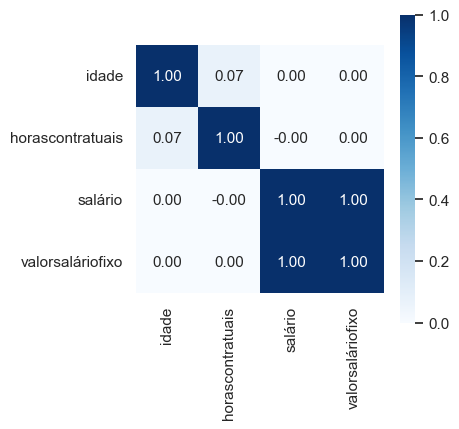

In [17]:
# Cálculo da correlação nos dados e apresentação gráfica do resultado
print("Matriz de Correlação")
cm = np.corrcoef(df_mov10_pd[colunas].values.T)
sns.set_theme(font_scale=1,rc = {'figure.figsize':(4,4)})
hm = sns.heatmap(cm, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 11}, 
                 yticklabels=colunas, 
                 xticklabels=colunas, 
                 cmap='Blues')
plt.show()

In [300]:
# Obter a lista de colunas
colunas = df_mov10_pd.columns.tolist()
colunas

['competênciamov',
 'região',
 'uf',
 'município',
 'seção',
 'subclasse',
 'saldomovimentação',
 'cbo2002ocupação',
 'categoria',
 'graudeinstrução',
 'idade',
 'horascontratuais',
 'raçacor',
 'sexo',
 'tipoempregador',
 'tipoestabelecimento',
 'tipomovimentação',
 'tipodedeficiência',
 'indtrabintermitente',
 'indtrabparcial',
 'salário',
 'tamestabjan',
 'indicadoraprendiz',
 'origemdainformação',
 'competênciadec',
 'indicadordeforadoprazo',
 'unidadesaláriocódigo',
 'valorsaláriofixo',
 'ano_mes']

**Iniciando a análise de componentes principais**

In [337]:
from sklearn.preprocessing import StandardScaler

valores_remover_pca = ['seção','competênciamov','indicadordeforadoprazo','uf','região']

X = df_mov10_pd.drop(columns=valores_remover_pca)
X_std = StandardScaler().fit_transform(X)

In [338]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) 

X_pca = pca.fit_transform(X_std)

In [339]:
pca.components_

array([[-7.88420646e-03,  3.18762146e-02, -5.43104194e-02,
        -1.87869732e-02,  4.73880318e-01, -7.20778154e-03,
         1.99660456e-02, -1.50257500e-02, -1.20468978e-02,
         8.71078697e-03,  1.63233511e-02, -2.01292080e-02,
        -1.57490387e-01, -3.30178000e-03,  4.73429742e-01,
         2.48220033e-02,  1.81147989e-04, -2.37161716e-02,
        -1.39638093e-02,  4.70629430e-01, -2.03934395e-01,
         4.63134450e-01,  3.16319941e-04, -2.03934395e-01],
       [ 3.26814232e-02, -3.64817015e-01, -2.93437624e-02,
         2.46663100e-01, -8.17033023e-03, -1.14305443e-01,
         7.27549946e-02,  1.61203135e-01,  6.67401271e-03,
        -2.00161225e-01,  4.88560550e-01,  4.58246122e-01,
        -7.47578721e-02, -4.90744181e-03, -8.75319750e-03,
        -2.38346076e-02,  1.76232141e-03,  4.93551626e-01,
        -7.77103144e-02, -9.92413772e-03, -8.61094516e-02,
        -1.05114278e-02,  1.77001367e-03, -8.61094516e-02]])

In [340]:
pca.explained_variance_

array([4.1154069 , 2.64809366])

In [341]:
pca.explained_variance_ratio_

array([0.17147514, 0.11033714])

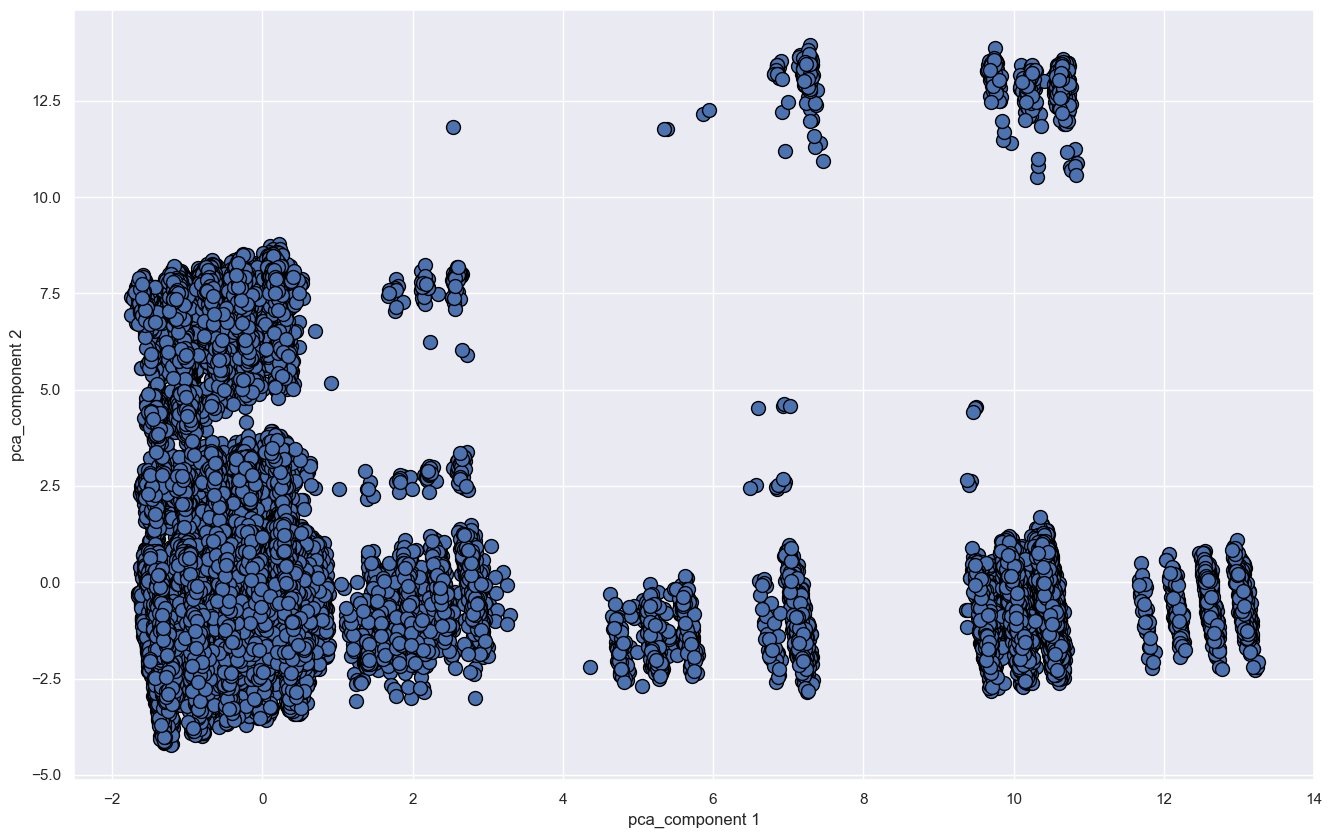

In [307]:
plt.scatter(X_pca[:,0], X_pca[:,1], edgecolor='black', s=100)
plt.xlabel('pca_component 1')
plt.ylabel('pca_component 2')
plt.show()

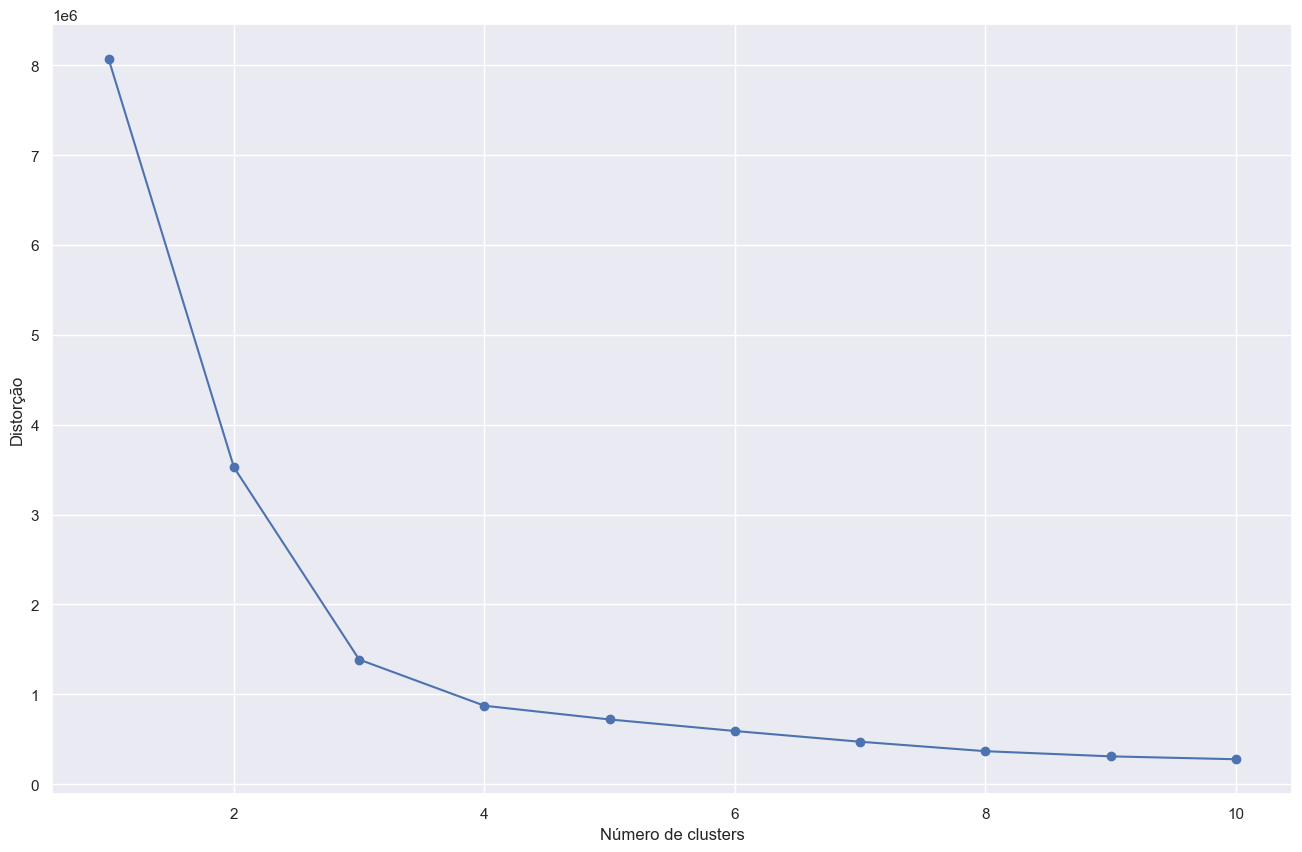

In [308]:
from sklearn.cluster import KMeans

#Aplicando o método do cotovelo para identificação do número ideal de clusters
distortions = []
for i in range (1,11):
    km = KMeans(
            n_clusters=i,
            init='k-means++',
            n_init=10,
            max_iter=300,
            random_state=42)
    km.fit(X_pca)
    distortions.append(km.inertia_)

plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Distorção')
plt.show;

In [ ]:
from sklearn.metrics import silhouette_samples

#Aplicando uma adaptação no método da silhueta para identificação do número ideal de clusters
silhueta=[]
for i in range (2,11):
    km = KMeans(
            n_clusters=i,
            init='k-means++',
            n_init=10,
            max_iter=300,
            random_state=42)
    y = km.fit_predict(X_pca)
    
    silhouette_vals = silhouette_samples(
        X_pca,
        y,
        metric='euclidean')

    silhouette_avg = np.mean(silhouette_vals)
    silhueta.append(silhouette_avg)

plt.plot(range(2,11), silhueta, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Silhueta')
plt.show;

In [342]:
kmeans = KMeans(
            n_clusters=3,
            init='k-means++',
            n_init=10,
            max_iter=300,
            random_state=42)
y_kmeans = kmeans.fit_predict(X_pca)

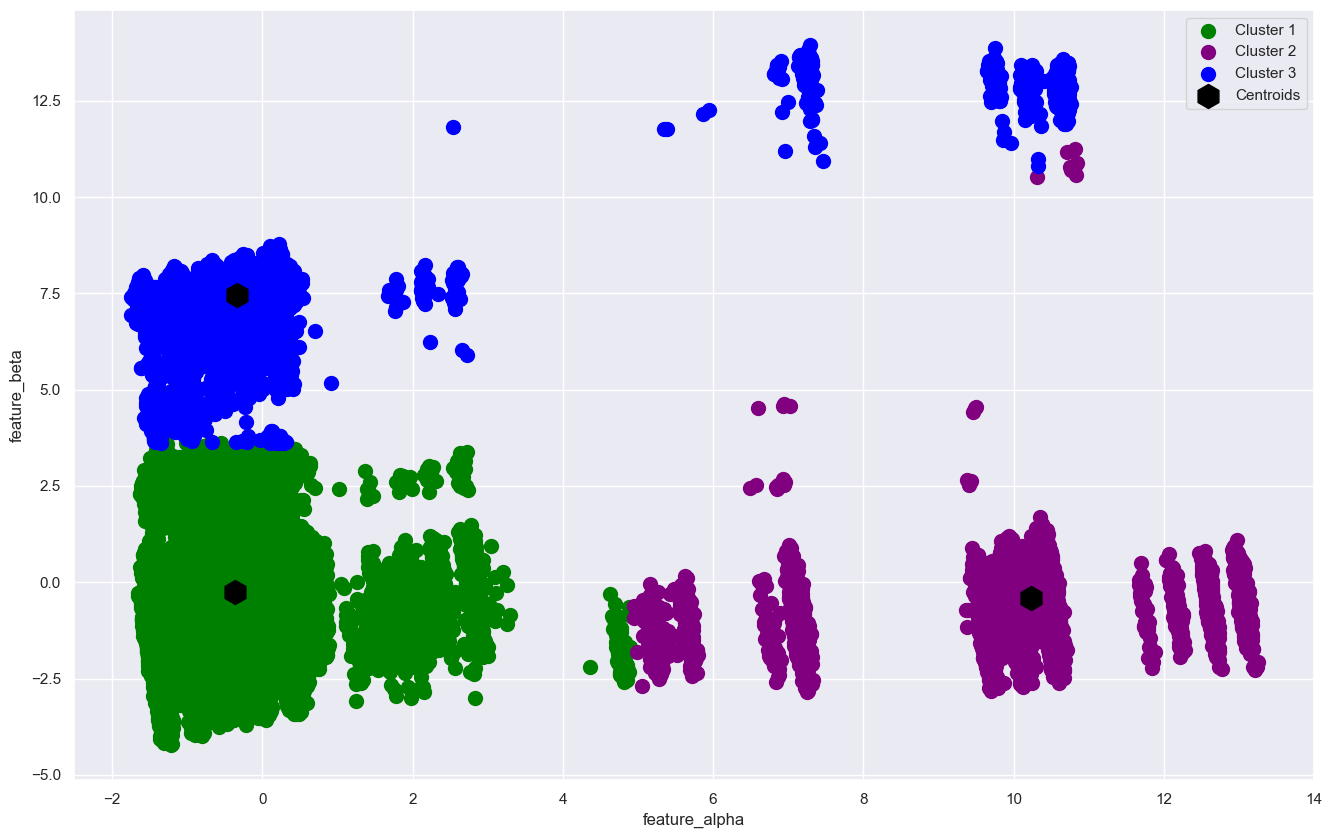

In [311]:
plt.scatter(X_pca[y_kmeans == 0, 0], X_pca[y_kmeans == 0, 1], s=100, c='green', label='Cluster 1')
plt.scatter(X_pca[y_kmeans == 1, 0], X_pca[y_kmeans == 1, 1], s=100, c='purple', label='Cluster 2')
plt.scatter(X_pca[y_kmeans == 2, 0], X_pca[y_kmeans == 2, 1], s=100, c='blue', label='Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='black', label='Centroids', marker='h')
plt.xlabel('feature_alpha')
plt.ylabel('feature_beta')
plt.legend()
plt.show()

In [20]:
# Carregar os dados do CAGED em df_mov10_pd (se já não estiver carregado)

# Converter a coluna 'ano_mes' para o formato de data
df_mov10_pd['ano_mes'] = pd.to_datetime(df_mov10_pd['ano_mes'], format='%Y%m')

# Calcular a soma da coluna 'saldomovimentação' mês a mês
resultado = df_mov10_pd.groupby(['cbo2002ocupação', 'ano_mes'])['saldomovimentação'].sum()

# Resetar o índice do resultado para transformá-lo em um DataFrame
resultado = resultado.reset_index()

# Renomear a coluna de soma para 'saldo_mes_ano'
resultado = resultado.rename(columns={'saldomovimentação': 'saldo_mes_ano'})

# Agregar os dados calculados ao DataFrame original df_mov10_pd usando a função merge()
df_mov10_pd = pd.merge(df_mov10_pd, resultado, on=['cbo2002ocupação', 'ano_mes'], how='left')

In [386]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

# Carregar o dataset
df = df_mov10_pd

# Selecionar as colunas relevaantes
columns = ['município', 'graudeinstrução', 'sexo', 'cbo2002ocupação', 'saldo_mes_ano']
df_selected = df[columns]

# Codificar as variáveis categóricas
encoder = LabelEncoder()
df_selected['município'] = encoder.fit_transform(df_selected['município'])
df_selected['graudeinstrução'] = encoder.fit_transform(df_selected['graudeinstrução'])
df_selected['sexo'] = encoder.fit_transform(df_selected['sexo'])
df_selected['saldo_mes_ano'] = encoder.fit_transform(df_selected['saldo_mes_ano'])

# Executar o K-means
k = 3  # número de clusters desejado
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(df_selected[['município', 'graudeinstrução', 'sexo', 'saldo_mes_ano']])

# Adicionar os rótulos dos clusters ao DataFrame
df_selected['cluster'] = kmeans.labels_

C:\Users\thiago.silva\AppData\Local\Temp\ipykernel_24276\314170567.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['município'] = encoder.fit_transform(df_selected['município'])
C:\Users\thiago.silva\AppData\Local\Temp\ipykernel_24276\314170567.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['graudeinstrução'] = encoder.fit_transform(df_selected['graudeinstrução'])
C:\Users\thiago.silva\AppData\Local\Temp\ipykernel_24276\314170567.py:16: SettingWithCopyWarning: 
A value is 

In [388]:
# Calcular o centróide de cada cluster
centroids = kmeans.cluster_centers_

# Encontrar os pontos de dados mais próximos aos centróides
df_selected['distance_to_centroid'] = kmeans.transform(
    df_selected[['município', 'graudeinstrução', 'sexo','saldo_mes_ano']]).min(axis=1)

# Encontrar a cbo2002ocupação correspondente ao centróide de cada cluster
centroid_cbo = []
for cluster in range(k):
    centroid_idx = df_selected[df_selected['cluster'] == cluster]['distance_to_centroid'].idxmin()
    centroid_cbo.append(df_selected.loc[centroid_idx, 'cbo2002ocupação'])

# Exibir as cbo2002ocupação dos centróides de cada cluster
for cluster, cbo in enumerate(centroid_cbo):
    print(f"Cluster {cluster+1}: CBO2002ocupação - {cbo}")

Cluster 1: CBO2002ocupação - 783225
Cluster 2: CBO2002ocupação - 724315
Cluster 3: CBO2002ocupação - 521130


C:\Users\thiago.silva\AppData\Local\Temp\ipykernel_24276\928303495.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['distance_to_centroid'] = kmeans.transform(


In [21]:
# Converter a coluna 'ano_mes' para o formato de data
df_mov10_pd['ano_mes'] = pd.to_datetime(df_mov10_pd['ano_mes'], format='%Y%m')

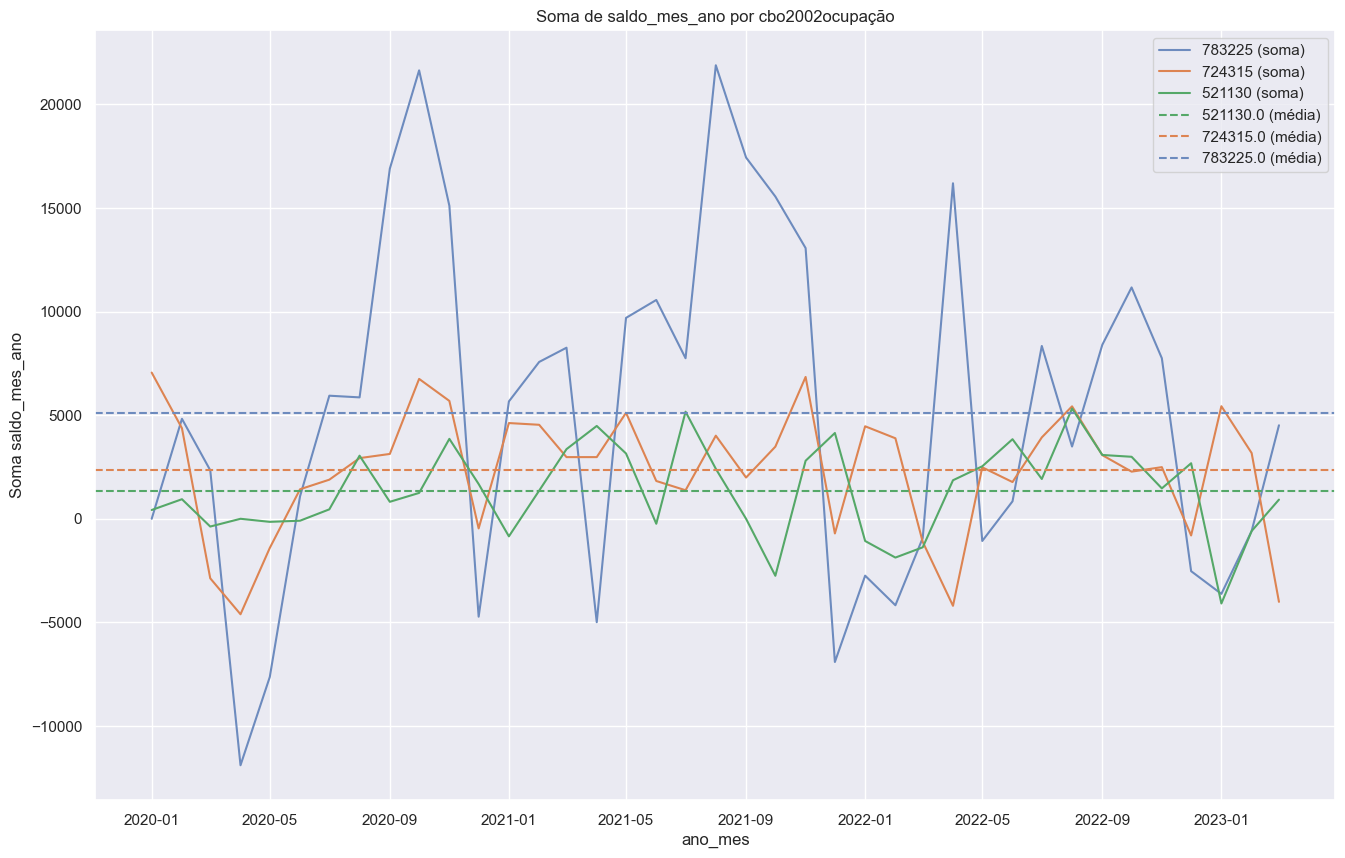

In [403]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados do CAGED em df_mov10_pd (se já não estiver carregado)

# Converter a coluna 'ano_mes' para o formato de data
df_mov10_pd['ano_mes'] = pd.to_datetime(df_mov10_pd['ano_mes'], format='%Y%m')

# Filtrar os dados para os códigos de cbo2002ocupação desejados
cbo_codes = [783225, 724315, 521130]
df_filtered = df_mov10_pd[df_mov10_pd['cbo2002ocupação'].isin(cbo_codes)]

# Calcular a soma de 'saldo_mes_ano' para cada 'ano_mes' e 'cbo2002ocupação'
df_grouped = df_filtered.groupby(['ano_mes', 'cbo2002ocupação'])['saldo_mes_ano'].sum().reset_index()

# Calcular a média histórica de 'saldo_mes_ano' para cada 'cbo2002ocupação'
df_mean = df_grouped.groupby('cbo2002ocupação')['saldo_mes_ano'].mean().reset_index()

# Definir as cores para cada 'cbo2002ocupação' usando valores RGB (0-255)
cbo_colors = {
    783225: (109, 139, 190),   # Azul
    724315: (221, 132, 82),   # Verde
    521130: (85, 168, 104)    # Vermelho
}

# Converter os valores RGB para o formato correto (0-1)
cbo_colors = {cbo: tuple(color / 255 for color in rgb) for cbo, rgb in cbo_colors.items()}

# Criar uma figura e um objeto de eixos
fig, ax = plt.subplots()

# Iterar sobre os códigos de cbo2002ocupação e criar uma linha para cada um
for cbo_code in cbo_codes:
    df_cbo = df_grouped[df_grouped['cbo2002ocupação'] == cbo_code]
    color = cbo_colors[cbo_code]
    ax.plot(df_cbo['ano_mes'], df_cbo['saldo_mes_ano'], label=f'{cbo_code} (soma)', color=color)

# Adicionar linhas para representar a média histórica de 'saldo_mes_ano' para cada 'cbo2002ocupação'
for _, row in df_mean.iterrows():
    cbo_code = row['cbo2002ocupação']
    mean_value = row['saldo_mes_ano']
    color = cbo_colors[cbo_code]
    ax.axhline(mean_value, linestyle='--', color=color, label=f'{cbo_code} (média)')

# Configurar o título do gráfico e os rótulos dos eixos
ax.set_title('Soma de saldo_mes_ano por cbo2002ocupação')
ax.set_xlabel('ano_mes')
ax.set_ylabel('Soma saldo_mes_ano')

# Adicionar uma legenda ao gráfico
ax.legend()

# Exibir o gráfico
plt.show()

In [26]:
arquivo_layout = 'C:/Users/thiago.silva/TCC/CAGED/Layout Novo Caged.xlsx'
aba_interesse = 'cbo2002ocupação'

# Carregue o arquivo Excel
df_cbo = pd.read_excel(arquivo_layout, sheet_name=aba_interesse)

# Acesse as descrições dos CBOs de interesse
cbo_interesse = [783225, 724315, 521130]

# Filtrar as linhas do DataFrame que correspondem aos CBOs de interesse
df_interesse = df_cbo[df_cbo['Código'].isin(cbo_interesse)]

# Exibir as descrições dos CBOs de interesse
print(df_interesse[['Código', 'Descrição']])

      Código                           Descrição
1612  521130  Atendente de Farmacia - Balconista
2015  724315                            Soldador
2409  783225               Ajudante de Motorista


**ANÁLISE DE SOBREVIVÊNCIA DE ATIVIDADE ECONÔMICA**

In [22]:
import numpy as np

# Recodificar a variável 'tipomovimentação' para criar a coluna 'flag_demissao'
df_mov10_pd['flag_demissao'] = np.where(
    (df_mov10_pd['tipomovimentação'] >= 31) & (df_mov10_pd['tipomovimentação'] <= 33) |
    (df_mov10_pd['tipomovimentação'] >= 40) & (df_mov10_pd['tipomovimentação'] <= 45) |
    (df_mov10_pd['tipomovimentação'] >= 50) & (df_mov10_pd['tipomovimentação'] <= 60) |
    (df_mov10_pd['tipomovimentação'] == 80) | (df_mov10_pd['tipomovimentação'] == 90) |
    (df_mov10_pd['tipomovimentação'] == 98),
    1,
    0
)

In [ ]:
!pip install lifelines

In [24]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from datetime import datetime, timedelta

Grupo 1: CBO 783225 (Ajudante de Motorista)
Quantos meses para atingir a mínima probabilidade de sobrevivência: 72.0 (02/2029)
Probabilidade de sobrevivência: 14.304457594068392

Grupo 2: CBO 724315 (Soldador)
Quantos meses para atingir a mínima probabilidade de sobrevivência: 43.0 (08/2026)
Probabilidade de sobrevivência: 15.82717111123686

Grupo 3: CBO 521130 (Atendente de Farmacia - Balconista)
Quantos meses para atingir a mínima probabilidade de sobrevivência: 34.0 (11/2025)
Probabilidade de sobrevivência: 15.651570644981646


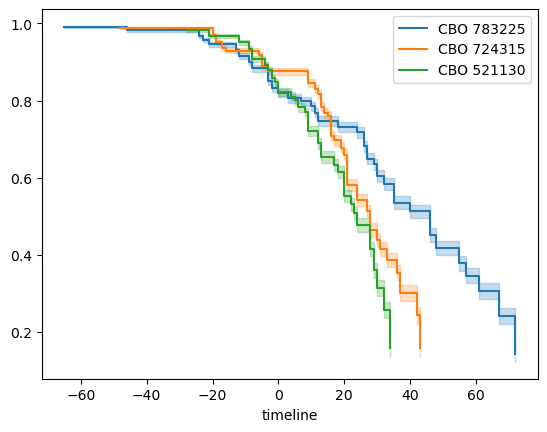

In [28]:
# Criar grupos
grupo1 = df_mov10_pd[df_mov10_pd['cbo2002ocupação'] == 783225]
grupo2 = df_mov10_pd[df_mov10_pd['cbo2002ocupação'] == 724315]
grupo3 = df_mov10_pd[df_mov10_pd['cbo2002ocupação'] == 521130]

# Definir tamanho mínimo para os grupos
min_size = min(grupo1.shape[0], grupo2.shape[0], grupo3.shape[0])

# Selecionar amostras aleatórias dos grupos
grupo1 = grupo1.sample(n=min_size, random_state=42)
grupo2 = grupo2.sample(n=min_size, random_state=42)
grupo3 = grupo3.sample(n=min_size, random_state=42)

# Verificar o comprimento dos dados
assert len(grupo1) == len(grupo2) == len(grupo3), "Os grupos têm comprimentos diferentes."

# Inicializar o estimador de Kaplan-Meier
kmf = KaplanMeierFitter()

# Definir a data base como março/2023
data_base = datetime(2023, 3, 1)

# Grupo 1
kmf.fit(grupo1['saldo_mes_ano'], grupo1['flag_demissao'], label='CBO 783225')
grupo1_survival = kmf.survival_function_
# Plote a curva de sobrevivência
kmf.plot_survival_function()
# Obter os valores da timeline e probabilidade para o Grupo 1
timeline_grupo = kmf.timeline
probabilidade_grupo = kmf.survival_function_

# Criar um DataFrame vazio
df = pd.DataFrame()
# Calcular a data resultante adicionando meses à data base
data_resultante = data_base + timedelta(days=30.44*timeline_grupo[-1])  # considerando 30.44 dias em um mês
# Criar a coluna com os meses e anos decorrentes
df['MesAnoDecorrente'] = pd.date_range(start=data_base, end=data_resultante, freq='M').strftime('%m/%Y')
# Obter o último valor da coluna "MesAnoDecorrente"
ultimo_valor = df['MesAnoDecorrente'].iloc[-1]

# Usando a função loc para obter a descrição correspondente ao código
descricao = df_interesse.loc[df_interesse['Código'] == 783225, 'Descrição'].values[0]

# Imprimir os valores para o Grupo 1
print(f'Grupo 1: CBO 783225 ({descricao})')
print(f'Quantos meses para atingir a mínima probabilidade de sobrevivência: {timeline_grupo[-1]} ({ultimo_valor})')
print('Probabilidade de sobrevivência: '+str(probabilidade_grupo['CBO 783225'].iloc[-1]*100))
print()

# Grupo 2
kmf.fit(grupo2['saldo_mes_ano'], grupo2['flag_demissao'], label='CBO 724315')
grupo2_survival = kmf.survival_function_
# Plote a curva de sobrevivência
kmf.plot_survival_function()
# Obter os valores da timeline e probabilidade para o Grupo 1
timeline_grupo = kmf.timeline
probabilidade_grupo = kmf.survival_function_

# Criar um DataFrame vazio
df = pd.DataFrame()
# Calcular a data resultante adicionando meses à data base
data_resultante = data_base + timedelta(days=30.44*timeline_grupo[-1])  # considerando 30.44 dias em um mês
# Criar a coluna com os meses e anos decorrentes
df['MesAnoDecorrente'] = pd.date_range(start=data_base, end=data_resultante, freq='M').strftime('%m/%Y')
# Obter o último valor da coluna "MesAnoDecorrente"
ultimo_valor = df['MesAnoDecorrente'].iloc[-1]

# Usando a função loc para obter a descrição correspondente ao código
descricao = df_interesse.loc[df_interesse['Código'] == 724315, 'Descrição'].values[0]

# Imprimir os valores para o Grupo 2
print(f'Grupo 2: CBO 724315 ({descricao})')
print(f'Quantos meses para atingir a mínima probabilidade de sobrevivência: {timeline_grupo[-1]} ({ultimo_valor})')
print('Probabilidade de sobrevivência: '+str(probabilidade_grupo['CBO 724315'].iloc[-1]*100))
print()

# Grupo 3
kmf.fit(grupo3['saldo_mes_ano'], grupo3['flag_demissao'], label='CBO 521130')
grupo3_survival = kmf.survival_function_
# Plote a curva de sobrevivência
kmf.plot_survival_function()
# Obter os valores da timeline e probabilidade para o Grupo 1
timeline_grupo = kmf.timeline
probabilidade_grupo = kmf.survival_function_

# Criar um DataFrame vazio
df = pd.DataFrame()
# Calcular a data resultante adicionando meses à data base
data_resultante = data_base + timedelta(days=30.44*timeline_grupo[-1])  # considerando 30.44 dias em um mês
# Criar a coluna com os meses e anos decorrentes
df['MesAnoDecorrente'] = pd.date_range(start=data_base, end=data_resultante, freq='M').strftime('%m/%Y')
# Obter o último valor da coluna "MesAnoDecorrente"
ultimo_valor = df['MesAnoDecorrente'].iloc[-1]

# Usando a função loc para obter a descrição correspondente ao código
descricao = df_interesse.loc[df_interesse['Código'] == 521130, 'Descrição'].values[0]
     
# Imprimir os valores para o Grupo 3
print(f'Grupo 3: CBO 521130 ({descricao})')
print(f'Quantos meses para atingir a mínima probabilidade de sobrevivência: {timeline_grupo[-1]} ({ultimo_valor})')
print('Probabilidade de sobrevivência: '+str(probabilidade_grupo['CBO 521130'].iloc[-1]*100))